In [1]:
# CHANGED FOR TPU 1VM:
# Install the local TF wheel
!pip install /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
!pip install -U tensorflow-addons
!pip install scikit-learn

Processing /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.6 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 70.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 25.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0.7
    Uninstalling flatbuffers-2.0.7:
      Successfully uninstalled flatbuffers-2.0.7
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    precision_score, recall_score, f1_score,
    jaccard_score, classification_report
)

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE

tf.compat.v1.enable_eager_execution()
#dataset = dataset.with_options(options)  # use this as input for your model

print("Tensorflow version " + tf.__version__)

2022-12-27 07:32:18.831094: I tensorflow/core/tpu/tpu_api_dlsym_initializer.cc:116] Libtpu path is: libtpu.so
[percpu.cc : 560] RAW: rseq syscall failed with errno 1
[percpu.cc : 552] RAW: rseq syscall failed with errno 1


Tensorflow version 2.9.1


In [3]:
# CHANGED FOR TPU 1VM:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
except tf.errors.NotFoundError:
    strategy = tf.distribute.MirroredStrategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2022-12-27 07:32:28.695378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 07:32:32.251267: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x5618397746f0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-12-27 07:32:32.251311: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): TPU, 2a886c8
2022-12-27 07:32:32.251322: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (1): TPU, 2a886c8
2022-12-27 07:32:32.251331: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (2): TPU, 2a886c8
2022-12-27 07:32:32.251339: I tensorflow/compiler/xla/service/service.cc:17

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
df = pd.read_csv("/kaggle/input/daphnet-dataset/data.csv")
df

,input0,input1,input2,input3,input4,input5,input6,input7,input8,input9,...,input759,input760,input761,input762,input763,input764,input765,input766,input767,label
0,-45.0,-18.0,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,...,181.0,202.0,202.0,171.0,202.0,212.0,202.0,202.0,191.0,0.0
1,-18.0,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,...,202.0,202.0,171.0,202.0,212.0,202.0,202.0,191.0,181.0,0.0
2,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,...,202.0,171.0,202.0,212.0,202.0,202.0,191.0,181.0,222.0,0.0
3,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,-163.0,...,171.0,202.0,212.0,202.0,202.0,191.0,181.0,222.0,212.0,0.0
4,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,-163.0,-236.0,...,202.0,212.0,202.0,202.0,191.0,181.0,222.0,212.0,202.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df = df.drop_duplicates()
df

,input0,input1,input2,input3,input4,input5,input6,input7,input8,input9,...,input759,input760,input761,input762,input763,input764,input765,input766,input767,label
0,-45.0,-18.0,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,...,181.0,202.0,202.0,171.0,202.0,212.0,202.0,202.0,191.0,0.0
1,-18.0,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,...,202.0,202.0,171.0,202.0,212.0,202.0,202.0,191.0,181.0,0.0
2,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,...,202.0,171.0,202.0,212.0,202.0,202.0,191.0,181.0,222.0,0.0
3,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,-163.0,...,171.0,202.0,212.0,202.0,202.0,191.0,181.0,222.0,212.0,0.0
4,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,-163.0,-236.0,...,202.0,212.0,202.0,202.0,191.0,181.0,222.0,212.0,202.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116802,-109.0,-109.0,-109.0,-109.0,-109.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1116803,-109.0,-109.0,-109.0,-109.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1116804,-109.0,-109.0,-109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1116805,-109.0,-109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
X = df.values[:, :-1]
X.shape

(1094288, 768)

In [12]:
y = df.label.astype(int).values
y

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 42)
X_train.shape

(875430, 768)

In [14]:
def train_fit_model(model):
    history = model.fit(
        x = X_train, y=y_train, validation_data=(X_val, y_val), 
        epochs=50, validation_steps=100,
        steps_per_epoch=100
    )
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    for i, metric in enumerate(["loss", "accuracy", "precision", "recall"]):
        axes[i // 2, i % 2].plot(history.history[metric], label="Training")
        axes[i // 2, i % 2].plot(history.history["val_"+metric], label="Validation")    
        axes[i // 2, i % 2].set_title(metric.title())
        axes[i // 2, i % 2].legend()
    
    plt.show()
    
    curves = pd.DataFrame(history.history)
    
    h_test = model.predict(X_test).round().flatten()
    
    # Compile Values into a Series Object for easy display
    values = pd.Series({
        "Accuracy":accuracy_score(y_test, h_test),
        "Precision":precision_score(y_test, h_test),
        "Recall":recall_score(y_test, h_test),
        "F1 Score":f1_score(y_test, h_test),
        "Jaccard Score":jaccard_score(y_test, h_test),
    })
    
    report = pd.DataFrame(classification_report(y_test, h_test, output_dict=True)).T
    
    print(values)
    return model, curves, values, report

2022-12-27 07:46:02.532199: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-27 07:46:02.558886: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2022-12-27 07:46:02.601403: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. RandomUniform
2022-12-27 07:46:09.531897: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  k

Epoch 1/50


2022-12-27 07:46:14.100446: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:254] Subgraph fingerprint:15991271983021282191
2022-12-27 07:46:14.307383: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 07:46:14.577314: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 07:46:15.136632: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(9459924834327185041), session_name()


  3/100 [..............................] - ETA: 4s - loss: 0.5385 - accuracy: 0.8948 - precision: 0.0000e+00 - recall: 0.0000e+00   

2022-12-27 07:46:17.849321: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 9459924834327185041 with session name  took 2.712573922s and succeeded
2022-12-27 07:46:17.862661: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(9459924834327185041), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_15991271983021282191", property.function_library_fingerprint = 5594776945946022172, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "1095,768,;1095,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:46:17.862734: I tensorflow/co

 99/100 [============================>.] - ETA: 0s - loss: 0.3379 - accuracy: 0.8990 - precision: 0.5645 - recall: 0.0108

2022-12-27 07:46:21.255843: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(2362686467665519396), session_name()


100/100 [==============================] - ETA: 0s - loss: 0.3375 - accuracy: 0.8990 - precision: 0.5650 - recall: 0.0107

2022-12-27 07:46:23.864906: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 2362686467665519396 with session name  took 2.608849996s and succeeded
2022-12-27 07:46:23.877454: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(2362686467665519396), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_15991271983021282191", property.function_library_fingerprint = 5594776945946022172, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "1086,768,;1086,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:46:23.877525: I tensorflow/co

100/100 [==============================] - 20s 123ms/step - loss: 0.3375 - accuracy: 0.8990 - precision: 0.5650 - recall: 0.0107 - val_loss: 0.3751 - val_accuracy: 0.8976 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
  1/100 [..............................] - ETA: 3s - loss: 0.3006 - accuracy: 0.8942 - precision: 1.0000 - recall: 0.0022

2022-12-27 07:46:30.075050: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 11439804199610445118 with session name  took 1.374376652s and succeeded
2022-12-27 07:46:30.079222: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(11439804199610445118), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_13571267013876370", property.function_library_fingerprint = 3646934047674302409, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "128,768,;128,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:46:30.079265: I tensorflow/core/t

100/100 [==============================] - 4s 45ms/step - loss: 0.2845 - accuracy: 0.8989 - precision: 0.8711 - recall: 0.0019 - val_loss: 0.3037 - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 4s 44ms/step - loss: 0.2706 - accuracy: 0.8988 - precision: 0.9109 - recall: 0.0010 - val_loss: 0.2846 - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
100/100 [==============================] - 4s 45ms/step - loss: 0.2602 - accuracy: 0.8990 - precision: 0.8084 - recall: 0.0030 - val_loss: 0.2816 - val_accuracy: 0.8976 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
100/100 [==============================] - 4s 45ms/step - loss: 0.2510 - accuracy: 0.8993 - precision: 0.6805 - recall: 0.0100 - val_loss: 0.2620 - val_accuracy: 0.8984 - val_precision: 0.6814 - val_recall: 0.0124
Epoch 6/50
100/100 [==============================] - 4s 45ms/step - loss: 0.2426 - acc

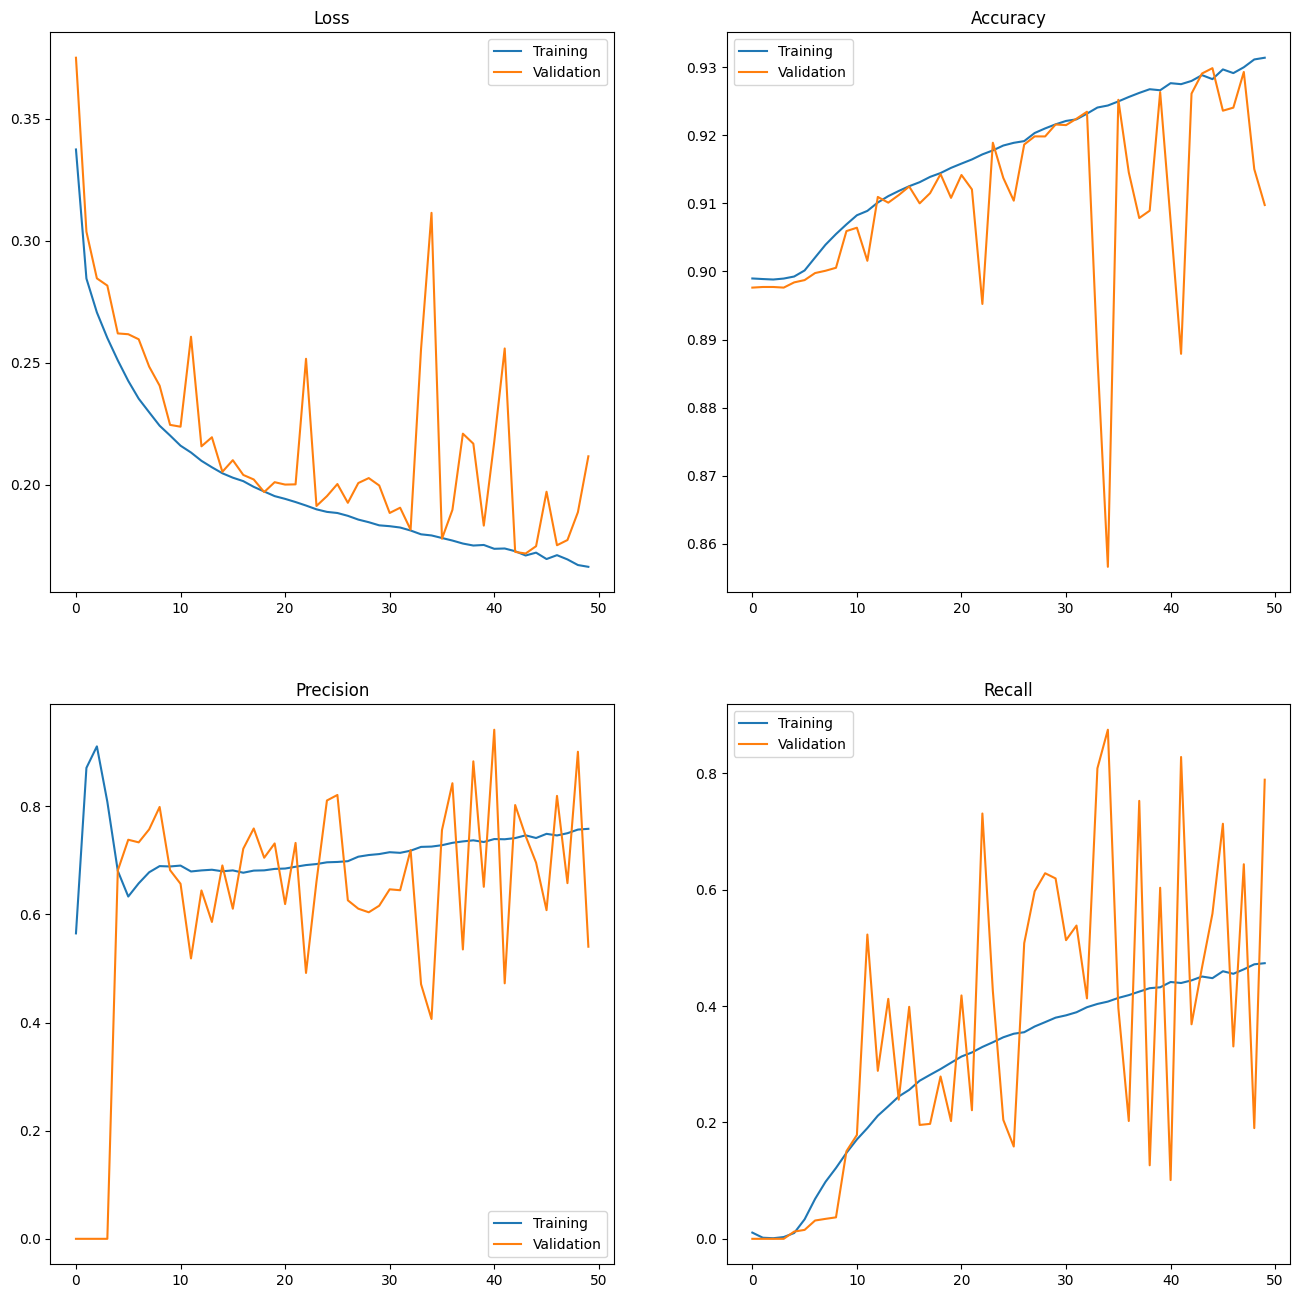

2022-12-27 07:50:13.703866: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_118010"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1662"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

  21/3420 [..............................] - ETA: 27s  

2022-12-27 07:50:15.386439: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 17499149028469290786 with session name  took 631.883229ms and succeeded
2022-12-27 07:50:15.388980: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(17499149028469290786), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_12765411764540539745", property.function_library_fingerprint = 17704425533155376850, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "4,768,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:50:15.389024: I tensorflow/core/t

3419/3420 [============================>.] - ETA: 0s

2022-12-27 07:50:42.208335: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(8181820139172060135), session_name()


3420/3420 [==============================] - 29s 8ms/step


2022-12-27 07:50:42.864642: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 8181820139172060135 with session name  took 656.223493ms and succeeded
2022-12-27 07:50:42.866789: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(8181820139172060135), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_12765411764540539745", property.function_library_fingerprint = 17704425533155376850, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "3,768,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:50:42.866833: I tensorflow/core/tpu

Accuracy         0.908827
Precision        0.529737
Recall           0.780338
F1 Score         0.631069
Jaccard Score    0.460994
dtype: float64


,precision,recall,f1-score,support
0,0.974,0.923,0.948,98494.000
1,0.530,0.780,0.631,10935.000
accuracy,0.909,0.909,0.909,0.909
macro avg,0.752,0.852,0.790,109429.000
weighted avg,0.930,0.909,0.916,109429.000


In [15]:
with strategy.scope():
    input_layer = keras.layers.Input((768, 1))

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(1, activation="sigmoid")(gap)

    cnn1d = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    cnn1d.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy', "Precision", "Recall"])

cnn1d, curves_cnn1d, values_cnn1d, report_cnn1d = train_fit_model(cnn1d)
cnn1d.save_weights("cnn1d_1.h5")
report_cnn1d.round(3)

2022-12-27 07:50:50.175147: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_150100"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1707"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

Epoch 1/50


2022-12-27 07:50:54.231464: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:254] Subgraph fingerprint:11154304644453244487
2022-12-27 07:50:54.382102: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 07:50:54.629905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 07:50:55.062562: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(13437598638313085252), session_name()


 13/100 [==>...........................] - ETA: 1s - loss: 32.5151 - accuracy: 0.8120 - precision: 0.1162 - recall: 0.1319

2022-12-27 07:50:56.375563: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 13437598638313085252 with session name  took 1.312832685s and succeeded
2022-12-27 07:50:56.383370: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(13437598638313085252), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_11154304644453244487", property.function_library_fingerprint = 1370170697036640901, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "1095,768,;1095,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:50:56.383420: I tensorflow/

 97/100 [============================>.] - ETA: 0s - loss: 4.9038 - accuracy: 0.8869 - precision: 0.1160 - recall: 0.0177

2022-12-27 07:50:57.707216: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(7726821854730991294), session_name()


100/100 [==============================] - ETA: 0s - loss: 4.7732 - accuracy: 0.8872 - precision: 0.1160 - recall: 0.0172

2022-12-27 07:50:59.422939: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 7726821854730991294 with session name  took 1.715588221s and succeeded
2022-12-27 07:50:59.430421: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(7726821854730991294), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_11154304644453244487", property.function_library_fingerprint = 1370170697036640901, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "1086,768,;1086,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:50:59.430472: I tensorflow/co

100/100 [==============================] - 13s 69ms/step - loss: 4.7732 - accuracy: 0.8872 - precision: 0.1160 - recall: 0.0172 - val_loss: 0.5343 - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
  5/100 [>.............................] - ETA: 1s - loss: 0.5288 - accuracy: 0.8978 - precision: 0.0000e+00 - recall: 0.0000e+00

2022-12-27 07:51:03.198117: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 7377841885211687950 with session name  took 467.440223ms and succeeded
2022-12-27 07:51:03.202271: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(7377841885211687950), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_9358101807529107678", property.function_library_fingerprint = 10351297379533041349, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "128,768,;128,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:51:03.202318: I tensorflow/core/

100/100 [==============================] - 3s 35ms/step - loss: 0.5254 - accuracy: 0.8987 - precision: 0.1364 - recall: 3.3838e-05 - val_loss: 0.5269 - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 3s 27ms/step - loss: 0.5183 - accuracy: 0.8987 - precision: 0.1667 - recall: 1.1279e-05 - val_loss: 0.5218 - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
100/100 [==============================] - 3s 27ms/step - loss: 0.5135 - accuracy: 0.8987 - precision: 0.2500 - recall: 1.1279e-05 - val_loss: 0.5177 - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
100/100 [==============================] - 3s 27ms/step - loss: 0.4979 - accuracy: 0.8987 - precision: 1.0000 - recall: 2.2559e-05 - val_loss: 0.4896 - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/50
100/100 [==============================] - 3s 27ms/s

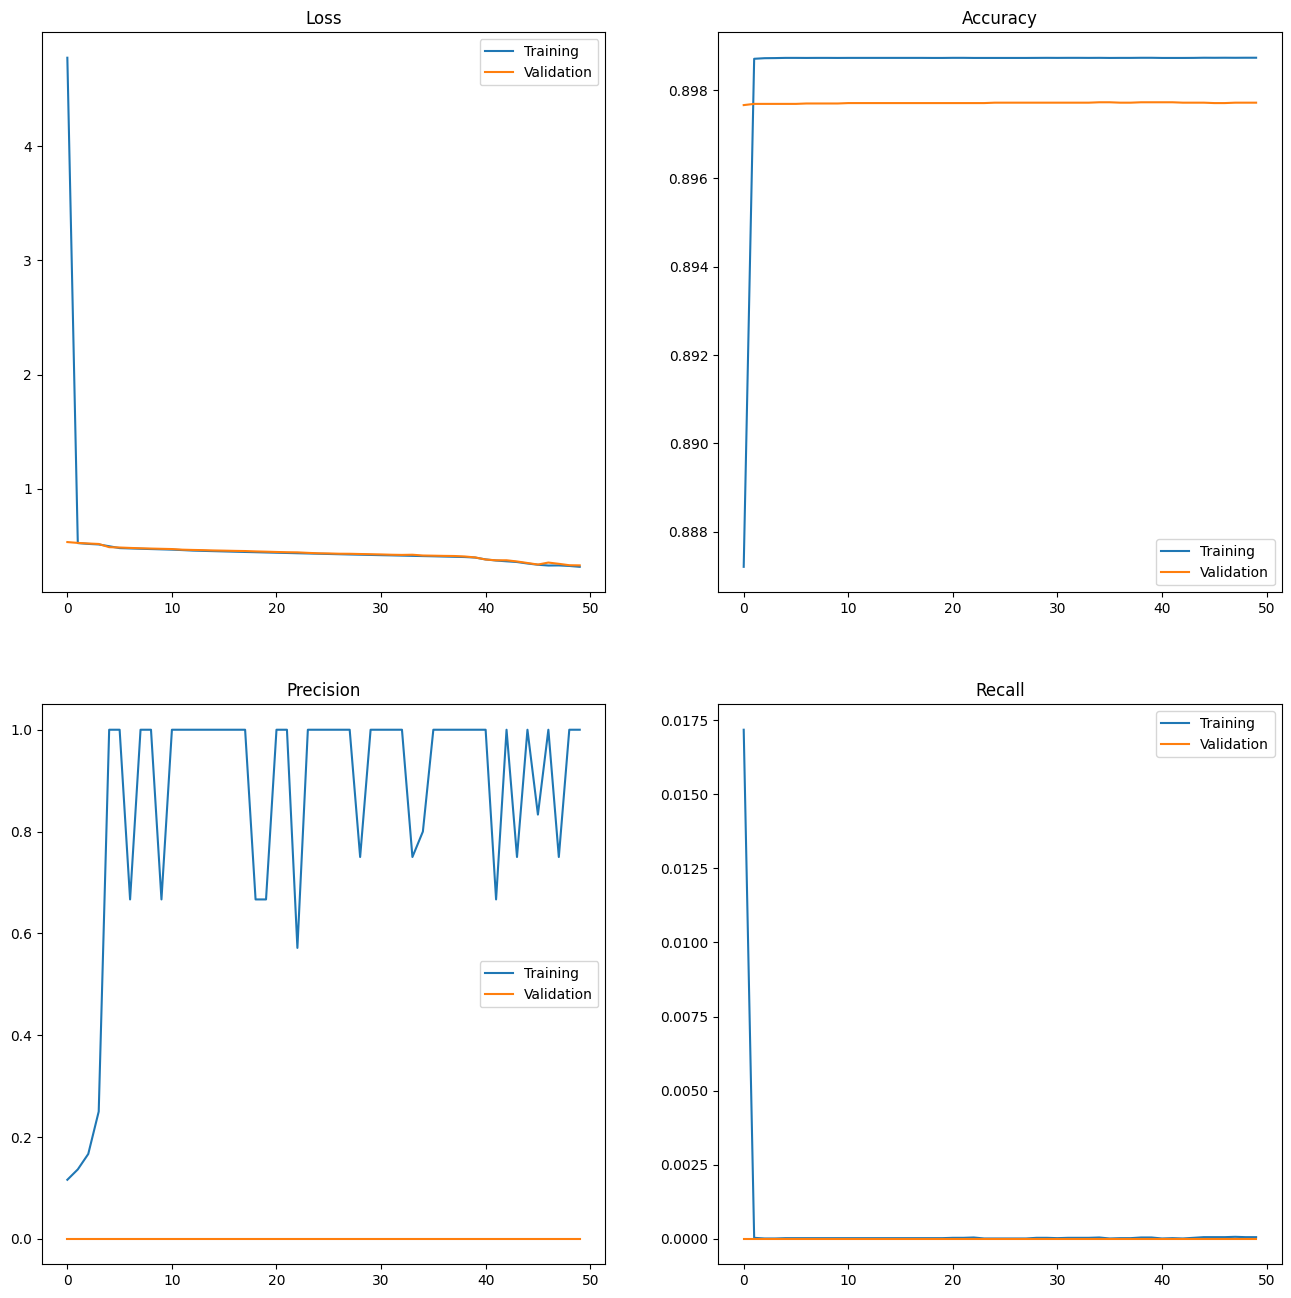

2022-12-27 07:53:19.063938: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_265855"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3365"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

3420/3420 [==============================] - 30s 8ms/step


2022-12-27 07:53:48.611759: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(16699370062127340263), session_name()
2022-12-27 07:53:48.766469: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 16699370062127340263 with session name  took 154.633031ms and succeeded
2022-12-27 07:53:48.768021: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(16699370062127340263), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_8563372534795537810", property.function_library_fingerprint = 10718977618945274855, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(prop

Accuracy         0.900045
Precision        0.200000
Recall           0.000091
F1 Score         0.000183
Jaccard Score    0.000091
dtype: float64


,precision,recall,f1-score,support
0,0.90,1.0,0.947,98494.0
1,0.20,0.0,0.000,10935.0
accuracy,0.90,0.9,0.900,0.9
macro avg,0.55,0.5,0.474,109429.0
weighted avg,0.83,0.9,0.853,109429.0


In [16]:
def neural_network(layers, lr=0.0001):
    with strategy.scope():    
        model = tf.keras.Sequential([
            *(tf.keras.layers.Dense(x, activation='relu') for x in layers),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy', "Precision", "Recall"])
        
        return model

nn1 = neural_network([1024, 256, 64, 8])
nn1, curves_nn1, values_nn1, report_nn1 = train_fit_model(nn1)
report_nn1.round(3)

In [17]:
nn1.save_weights("nn1.h5")

2022-12-27 07:53:55.702975: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_297791"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3410"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

Epoch 1/50


2022-12-27 07:53:59.749492: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:254] Subgraph fingerprint:6737821563862147343
2022-12-27 07:53:59.886752: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 07:54:00.111042: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 07:54:00.483436: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(9605351163008181229), session_name()


 13/100 [==>...........................] - ETA: 1s - loss: 44.7449 - accuracy: 0.7941 - precision: 0.1210 - recall: 0.1691

2022-12-27 07:54:01.823772: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 9605351163008181229 with session name  took 1.340179729s and succeeded
2022-12-27 07:54:01.830523: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(9605351163008181229), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_6737821563862147343", property.function_library_fingerprint = 10202446449267333970, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "1095,768,;1095,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:54:01.830574: I tensorflow/co

 97/100 [============================>.] - ETA: 0s - loss: 13.1052 - accuracy: 0.8362 - precision: 0.1946 - recall: 0.1969

2022-12-27 07:54:03.175879: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(9584078717460725529), session_name()


100/100 [==============================] - ETA: 0s - loss: 12.8547 - accuracy: 0.8367 - precision: 0.1961 - recall: 0.1977

2022-12-27 07:54:04.829925: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 9584078717460725529 with session name  took 1.653853566s and succeeded
2022-12-27 07:54:04.836720: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(9584078717460725529), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_6737821563862147343", property.function_library_fingerprint = 10202446449267333970, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "1086,768,;1086,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:54:04.836770: I tensorflow/co

100/100 [==============================] - 12s 68ms/step - loss: 12.8547 - accuracy: 0.8367 - precision: 0.1961 - recall: 0.1977 - val_loss: 4.6617 - val_accuracy: 0.8370 - val_precision: 0.2336 - val_recall: 0.2603
Epoch 2/50
  5/100 [>.............................] - ETA: 1s - loss: 4.3757 - accuracy: 0.8509 - precision: 0.2346 - recall: 0.2358

2022-12-27 07:54:08.570776: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 9070699630412232872 with session name  took 487.177099ms and succeeded
2022-12-27 07:54:08.574489: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(9070699630412232872), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_260800218336065588", property.function_library_fingerprint = 15405098290389296836, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "128,768,;128,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:54:08.574556: I tensorflow/core/t

100/100 [==============================] - 3s 27ms/step - loss: 3.6947 - accuracy: 0.8509 - precision: 0.2597 - recall: 0.2550 - val_loss: 3.0722 - val_accuracy: 0.8498 - val_precision: 0.2697 - val_recall: 0.2744
Epoch 3/50
100/100 [==============================] - 3s 26ms/step - loss: 2.6951 - accuracy: 0.8557 - precision: 0.2851 - recall: 0.2817 - val_loss: 2.3935 - val_accuracy: 0.8660 - val_precision: 0.3094 - val_recall: 0.2519
Epoch 4/50
100/100 [==============================] - 3s 28ms/step - loss: 2.3700 - accuracy: 0.8603 - precision: 0.3041 - recall: 0.2942 - val_loss: 4.7877 - val_accuracy: 0.8971 - val_precision: 0.4772 - val_recall: 0.0644
Epoch 5/50
100/100 [==============================] - 3s 26ms/step - loss: 1.8813 - accuracy: 0.8626 - precision: 0.3168 - recall: 0.3083 - val_loss: 1.6749 - val_accuracy: 0.8340 - val_precision: 0.2878 - val_recall: 0.4222
Epoch 6/50
100/100 [==============================] - 3s 27ms/step - loss: 1.7096 - accuracy: 0.8630 - precisio

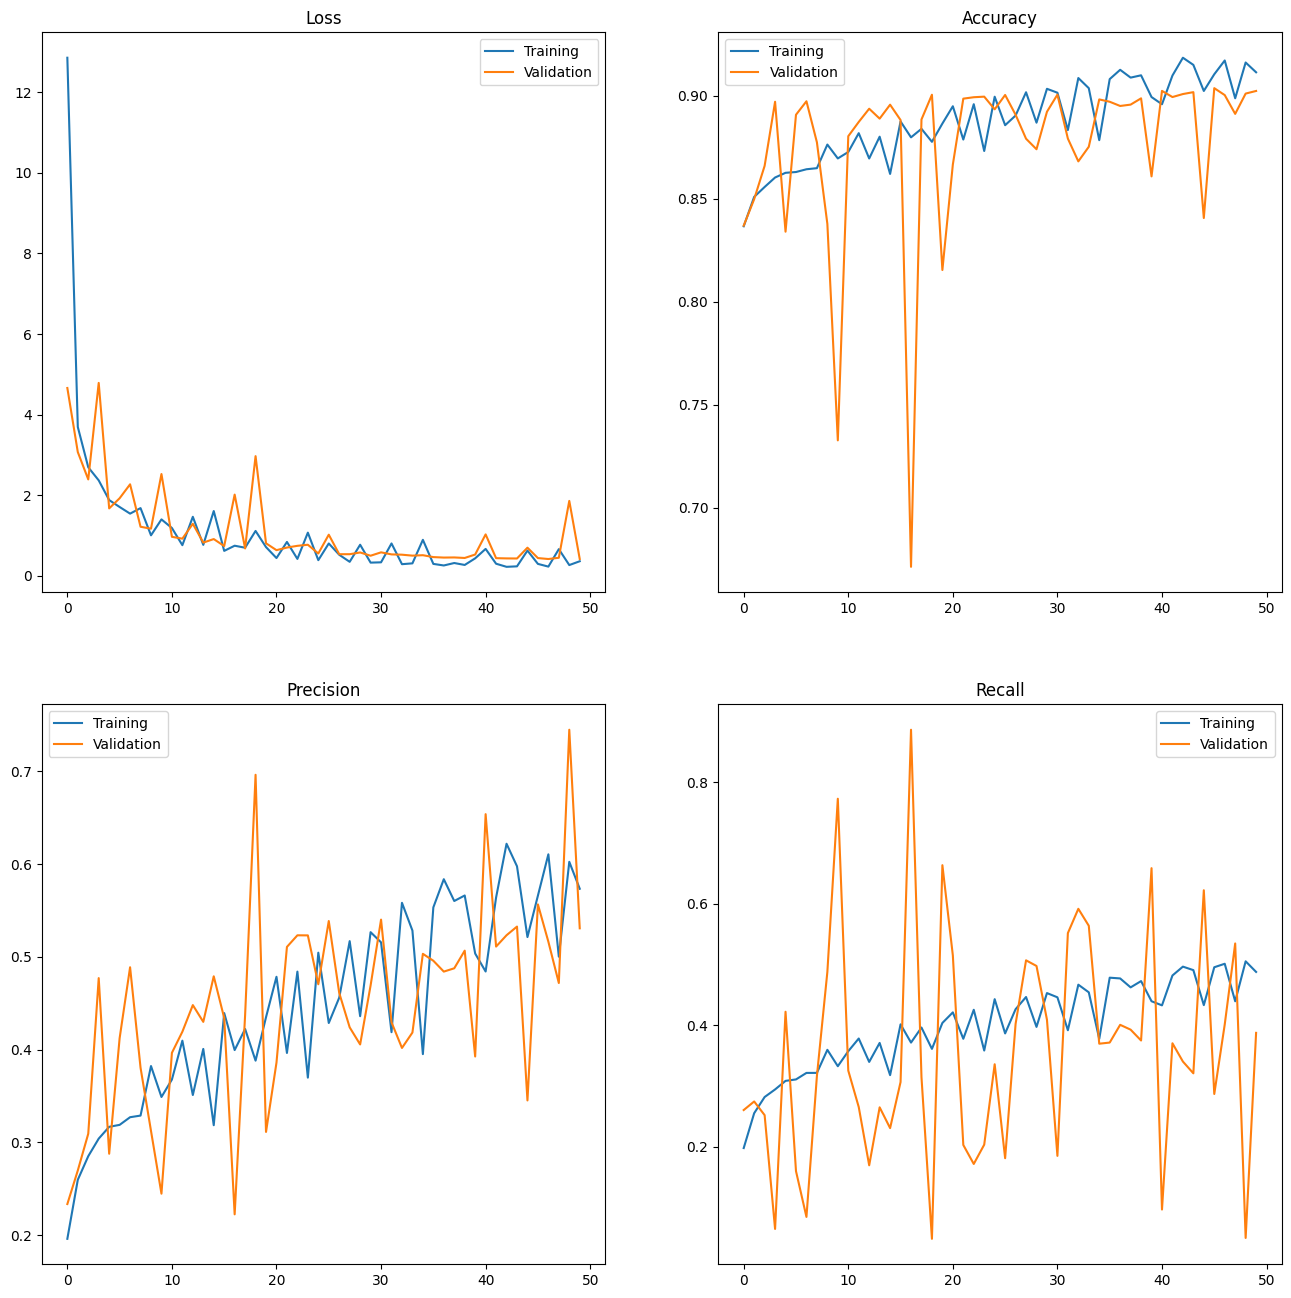

2022-12-27 07:56:23.142217: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_413252"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:5068"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

   1/3420 [..............................] - ETA: 1:45:05

2022-12-27 07:56:24.847091: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(14432500045001715076), session_name()
2022-12-27 07:56:24.991831: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 14432500045001715076 with session name  took 144.66813ms and succeeded
2022-12-27 07:56:24.993167: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(14432500045001715076), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_15760667385383816495", property.function_library_fingerprint = 17076302279492161787, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(prop

3420/3420 [==============================] - 31s 9ms/step


2022-12-27 07:56:54.121171: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(6248615908755989378), session_name()
2022-12-27 07:56:54.276826: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 6248615908755989378 with session name  took 155.569487ms and succeeded
2022-12-27 07:56:54.278509: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(6248615908755989378), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_15760667385383816495", property.function_library_fingerprint = 17076302279492161787, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(proper

Accuracy         0.903600
Precision        0.523910
Recall           0.386740
F1 Score         0.444994
Jaccard Score    0.286169
dtype: float64


,precision,recall,f1-score,support
0,0.934,0.961,0.947,98494.000
1,0.524,0.387,0.445,10935.000
accuracy,0.904,0.904,0.904,0.904
macro avg,0.729,0.674,0.696,109429.000
weighted avg,0.893,0.904,0.897,109429.000


In [18]:
nn2 = neural_network([1024, 256, 64])
nn2, curves_nn2, values_nn2, report_nn2 = train_fit_model(nn2)
nn2.save_weights("nn2.h5")
report_nn2.round(3)

2022-12-27 07:57:01.450728: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_445173"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:5113"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

Epoch 1/50


2022-12-27 07:57:04.508042: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:254] Subgraph fingerprint:3658801113058025410
2022-12-27 07:57:04.630891: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 07:57:04.833348: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 07:57:05.144038: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(4164892571842236657), session_name()


 13/100 [==>...........................] - ETA: 1s - loss: 35.5239 - accuracy: 0.8257 - precision: 0.1650 - recall: 0.1748

2022-12-27 07:57:06.239129: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 4164892571842236657 with session name  took 1.094934325s and succeeded
2022-12-27 07:57:06.245002: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(4164892571842236657), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_3658801113058025410", property.function_library_fingerprint = 12211845591846454705, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "1095,768,;1095,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:57:06.245054: I tensorflow/co

 99/100 [============================>.] - ETA: 0s - loss: 14.8728 - accuracy: 0.8444 - precision: 0.2299 - recall: 0.2284

2022-12-27 07:57:07.667929: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(2305295950141182139), session_name()


100/100 [==============================] - ETA: 0s - loss: 14.8022 - accuracy: 0.8442 - precision: 0.2302 - recall: 0.2297

2022-12-27 07:57:09.421261: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 2305295950141182139 with session name  took 1.753185284s and succeeded
2022-12-27 07:57:09.428036: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(2305295950141182139), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_3658801113058025410", property.function_library_fingerprint = 12211845591846454705, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "1086,768,;1086,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:57:09.428094: I tensorflow/co

100/100 [==============================] - 11s 69ms/step - loss: 14.8022 - accuracy: 0.8442 - precision: 0.2302 - recall: 0.2297 - val_loss: 7.8591 - val_accuracy: 0.8729 - val_precision: 0.3103 - val_recall: 0.1982
Epoch 2/50
  5/100 [>.............................] - ETA: 1s - loss: 7.7957 - accuracy: 0.8575 - precision: 0.2844 - recall: 0.2665

2022-12-27 07:57:13.080265: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 93218869971958822 with session name  took 427.001258ms and succeeded
2022-12-27 07:57:13.083897: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(93218869971958822), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_10789673292381207784", property.function_library_fingerprint = 18282428744245101411, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "128,768,;128,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:57:13.083950: I tensorflow/core/tpu

100/100 [==============================] - 3s 27ms/step - loss: 6.6247 - accuracy: 0.8576 - precision: 0.2946 - recall: 0.2913 - val_loss: 5.5592 - val_accuracy: 0.8408 - val_precision: 0.2880 - val_recall: 0.3777
Epoch 3/50
100/100 [==============================] - 3s 26ms/step - loss: 6.1023 - accuracy: 0.8614 - precision: 0.3148 - recall: 0.3135 - val_loss: 4.6018 - val_accuracy: 0.8667 - val_precision: 0.3400 - val_recall: 0.3227
Epoch 4/50
100/100 [==============================] - 3s 26ms/step - loss: 5.4021 - accuracy: 0.8630 - precision: 0.3236 - recall: 0.3237 - val_loss: 5.7241 - val_accuracy: 0.8951 - val_precision: 0.4576 - val_recall: 0.1408
Epoch 5/50
100/100 [==============================] - 3s 26ms/step - loss: 3.9917 - accuracy: 0.8701 - precision: 0.3549 - recall: 0.3456 - val_loss: 4.4204 - val_accuracy: 0.8817 - val_precision: 0.3779 - val_recall: 0.2419
Epoch 6/50
100/100 [==============================] - 3s 27ms/step - loss: 4.7909 - accuracy: 0.8668 - precisio

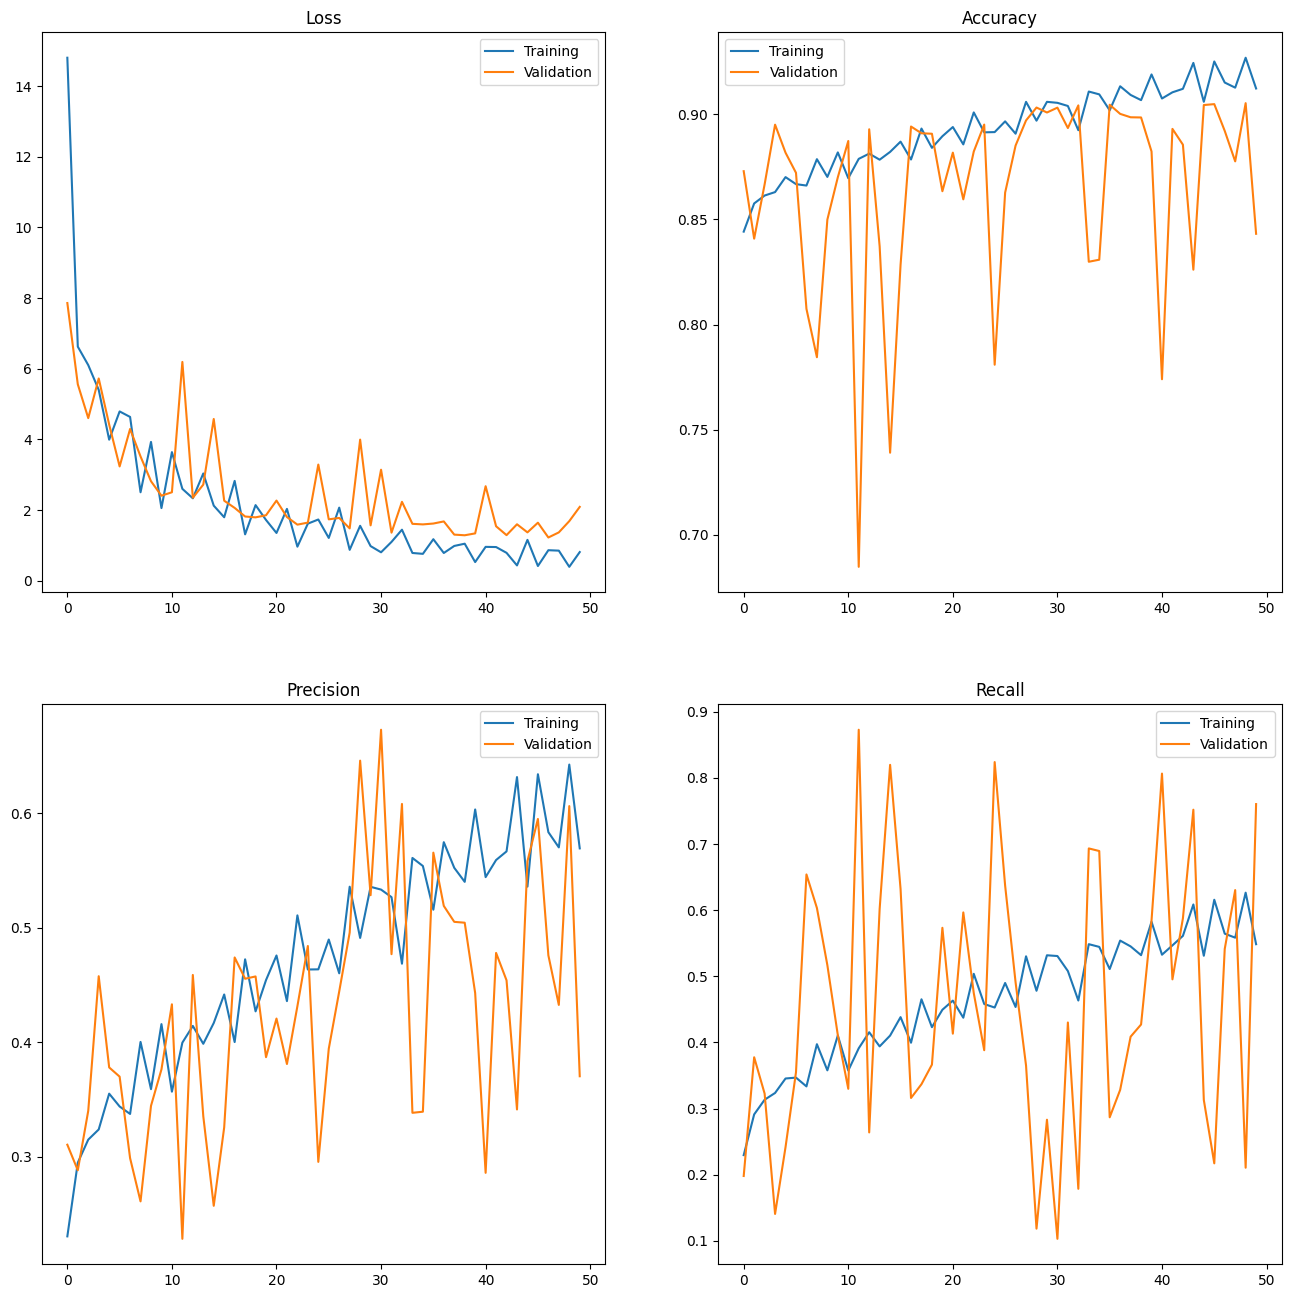

2022-12-27 07:59:29.168540: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_560340"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:6771"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

  19/3420 [..............................] - ETA: 31s

2022-12-27 07:59:30.185716: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 13840929502447361886 with session name  took 135.787294ms and succeeded
2022-12-27 07:59:30.186869: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(13840929502447361886), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_6624265989437695627", property.function_library_fingerprint = 4349148622717019644, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "4,768,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 07:59:30.186913: I tensorflow/core/tpu

3420/3420 [==============================] - 30s 9ms/step


2022-12-27 07:59:59.358675: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(6898160137732201788), session_name()
2022-12-27 07:59:59.506954: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 6898160137732201788 with session name  took 148.185412ms and succeeded
2022-12-27 07:59:59.508722: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(6898160137732201788), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_6624265989437695627", property.function_library_fingerprint = 4349148622717019644, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property

Accuracy         0.841989
Precision        0.360809
Recall           0.753361
F1 Score         0.487932
Jaccard Score    0.322692
dtype: float64


,precision,recall,f1-score,support
0,0.969,0.852,0.907,98494.000
1,0.361,0.753,0.488,10935.000
accuracy,0.842,0.842,0.842,0.842
macro avg,0.665,0.803,0.697,109429.000
weighted avg,0.908,0.842,0.865,109429.000


In [19]:
nn3 = neural_network([1024, 256])
nn3, curves_nn3, values_nn3, report_nn3 = train_fit_model(nn3)
nn3.save_weights("nn3.h5")
report_nn3.round(3)

2022-12-27 08:00:06.847645: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_592246"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:6816"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

Epoch 1/50


2022-12-27 08:00:09.794378: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:254] Subgraph fingerprint:5740996985995616327
2022-12-27 08:00:09.901994: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 08:00:10.092946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 08:00:10.354628: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(13900297792031562881), session_name()


 13/100 [==>...........................] - ETA: 1s - loss: 61.0390 - accuracy: 0.8232 - precision: 0.1214 - recall: 0.1167

2022-12-27 08:00:11.512830: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 13900297792031562881 with session name  took 1.157375087s and succeeded
2022-12-27 08:00:11.518796: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(13900297792031562881), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_5740996985995616327", property.function_library_fingerprint = 6755464889328714571, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "1095,768,;1095,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 08:00:11.518841: I tensorflow/c

 97/100 [============================>.] - ETA: 0s - loss: 27.1614 - accuracy: 0.8356 - precision: 0.1891 - recall: 0.1902

2022-12-27 08:00:12.888706: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(15650354430534469470), session_name()


100/100 [==============================] - ETA: 0s - loss: 26.7584 - accuracy: 0.8357 - precision: 0.1906 - recall: 0.1918

2022-12-27 08:00:14.876119: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 15650354430534469470 with session name  took 1.987315935s and succeeded
2022-12-27 08:00:14.882562: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(15650354430534469470), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_5740996985995616327", property.function_library_fingerprint = 6755464889328714571, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "1086,768,;1086,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 08:00:14.882621: I tensorflow/c

100/100 [==============================] - 11s 70ms/step - loss: 26.7584 - accuracy: 0.8357 - precision: 0.1906 - recall: 0.1918 - val_loss: 13.9513 - val_accuracy: 0.8610 - val_precision: 0.2461 - val_recall: 0.1739
Epoch 2/50
  5/100 [>.............................] - ETA: 1s - loss: 13.3166 - accuracy: 0.8487 - precision: 0.2370 - recall: 0.2223

2022-12-27 08:00:18.405920: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 1890212388922436975 with session name  took 357.168327ms and succeeded
2022-12-27 08:00:18.409092: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(1890212388922436975), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_12534781655109916092", property.function_library_fingerprint = 11661257431399339701, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "128,768,;128,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 08:00:18.409137: I tensorflow/core

100/100 [==============================] - 3s 26ms/step - loss: 13.3927 - accuracy: 0.8476 - precision: 0.2456 - recall: 0.2438 - val_loss: 9.9216 - val_accuracy: 0.8596 - val_precision: 0.2865 - val_recall: 0.2500
Epoch 3/50
100/100 [==============================] - 3s 27ms/step - loss: 11.0044 - accuracy: 0.8524 - precision: 0.2693 - recall: 0.2668 - val_loss: 8.5442 - val_accuracy: 0.8692 - val_precision: 0.3189 - val_recall: 0.2455
Epoch 4/50
100/100 [==============================] - 3s 26ms/step - loss: 7.6526 - accuracy: 0.8597 - precision: 0.3067 - recall: 0.3057 - val_loss: 7.3866 - val_accuracy: 0.8755 - val_precision: 0.3428 - val_recall: 0.2374
Epoch 5/50
100/100 [==============================] - 3s 27ms/step - loss: 10.6458 - accuracy: 0.8560 - precision: 0.2889 - recall: 0.2884 - val_loss: 7.4446 - val_accuracy: 0.8854 - val_precision: 0.3823 - val_recall: 0.1957
Epoch 6/50
100/100 [==============================] - 3s 26ms/step - loss: 8.7655 - accuracy: 0.8608 - preci

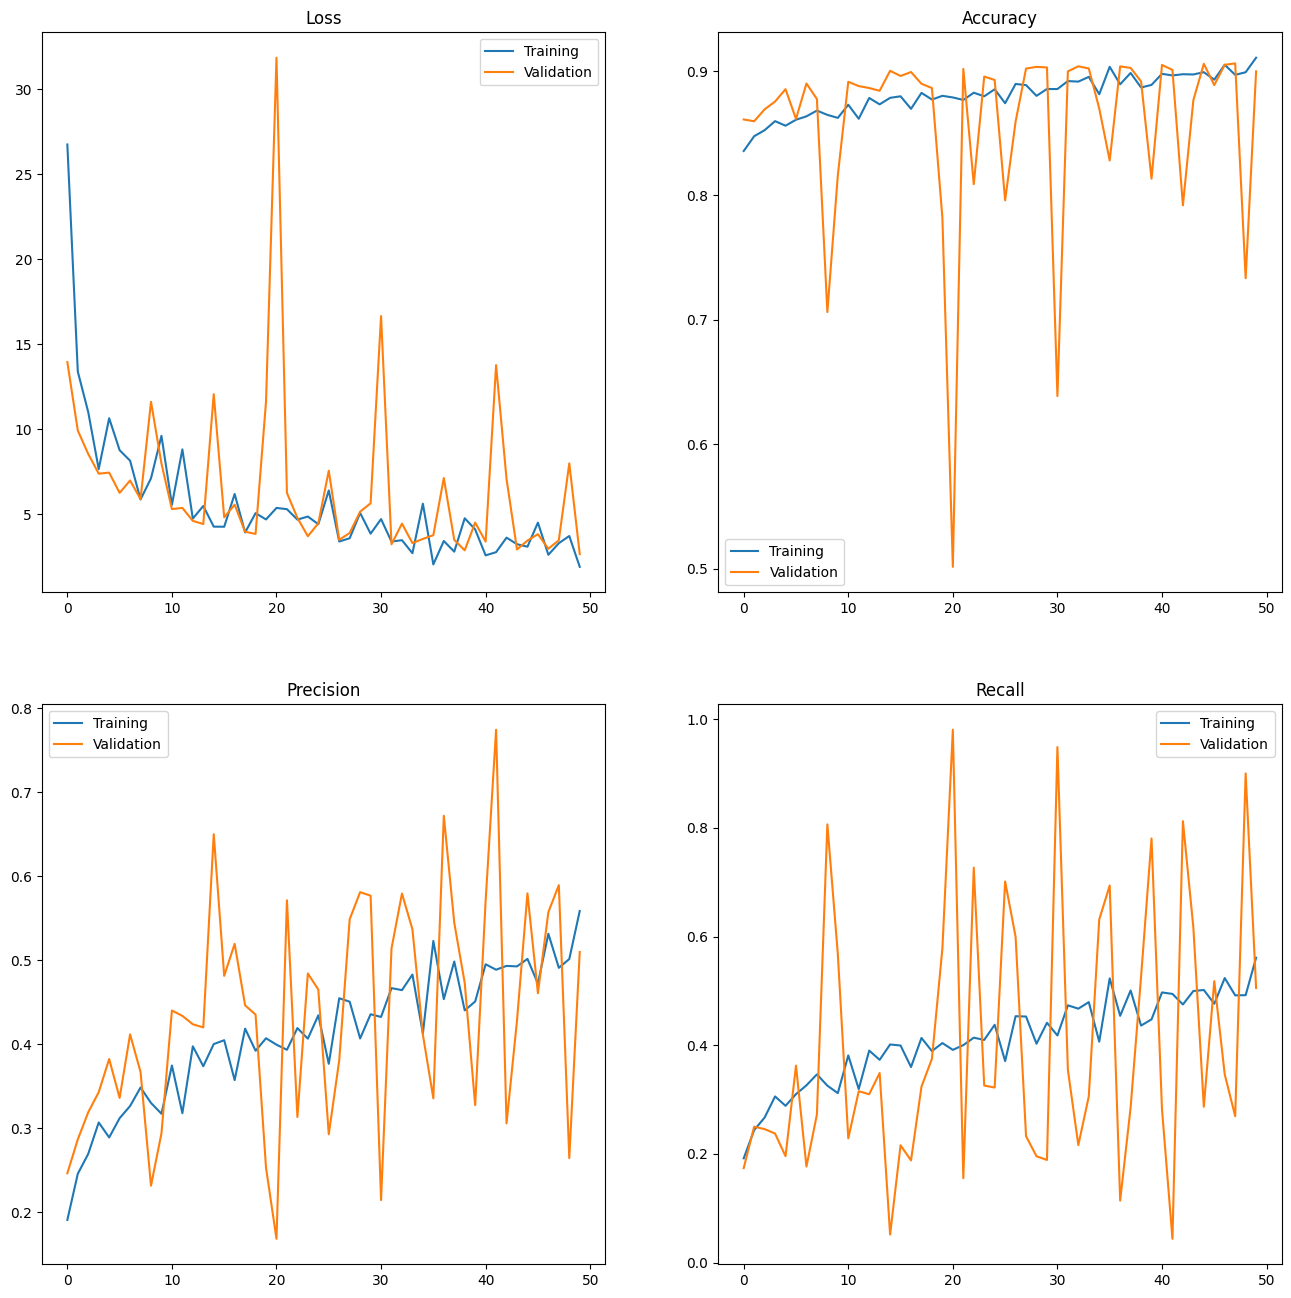

2022-12-27 08:02:35.446998: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_707119"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:8474"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

  18/3420 [..............................] - ETA: 31s

2022-12-27 08:02:36.394344: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 16764918059074783823 with session name  took 96.630242ms and succeeded
2022-12-27 08:02:36.395757: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(16764918059074783823), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_16157546897019166271", property.function_library_fingerprint = 18374745227966948476, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "4,768,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 08:02:36.395803: I tensorflow/core/tp

3420/3420 [==============================] - 31s 9ms/step


2022-12-27 08:03:05.926855: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(14466095997450232474), session_name()
2022-12-27 08:03:06.018178: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 14466095997450232474 with session name  took 91.228514ms and succeeded
2022-12-27 08:03:06.019405: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(14466095997450232474), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_16157546897019166271", property.function_library_fingerprint = 18374745227966948476, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(prop

Accuracy         0.899140
Precision        0.495422
Recall           0.504710
F1 Score         0.500023
Jaccard Score    0.333353
dtype: float64


,precision,recall,f1-score,support
0,0.945,0.943,0.944,98494.000
1,0.495,0.505,0.500,10935.000
accuracy,0.899,0.899,0.899,0.899
macro avg,0.720,0.724,0.722,109429.000
weighted avg,0.900,0.899,0.900,109429.000


In [20]:
nn4 = neural_network([1024])
nn4, curves_nn4, values_nn4, report_nn4 = train_fit_model(nn4)
nn4.save_weights("nn4.h5")
report_nn4.round(3)

2022-12-27 08:03:13.055963: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_739010"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:8519"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

Epoch 1/50


2022-12-27 08:03:16.474667: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:254] Subgraph fingerprint:7954340930954201773
2022-12-27 08:03:16.579078: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 08:03:16.762558: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 08:03:17.075402: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(17569812096654777135), session_name()


 13/100 [==>...........................] - ETA: 1s - loss: 108.7556 - accuracy: 0.8417 - precision: 0.1227 - recall: 0.0919

2022-12-27 08:03:19.128886: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 17569812096654777135 with session name  took 2.053345211s and succeeded
2022-12-27 08:03:19.134710: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(17569812096654777135), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_7954340930954201773", property.function_library_fingerprint = 13710132481654478616, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "1095,768,;1095,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 08:03:19.134761: I tensorflow/

 97/100 [============================>.] - ETA: 0s - loss: 33.2123 - accuracy: 0.8387 - precision: 0.2033 - recall: 0.2027

2022-12-27 08:03:20.466038: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(10513132242564306571), session_name()


100/100 [==============================] - ETA: 0s - loss: 32.5320 - accuracy: 0.8393 - precision: 0.2043 - recall: 0.2029

2022-12-27 08:03:22.556374: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 10513132242564306571 with session name  took 2.090233246s and succeeded
2022-12-27 08:03:22.562015: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(10513132242564306571), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_7954340930954201773", property.function_library_fingerprint = 13710132481654478616, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "1086,768,;1086,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 08:03:22.562067: I tensorflow/

100/100 [==============================] - 13s 72ms/step - loss: 32.5320 - accuracy: 0.8393 - precision: 0.2043 - recall: 0.2029 - val_loss: 10.1483 - val_accuracy: 0.8327 - val_precision: 0.2504 - val_recall: 0.3186
Epoch 2/50
  5/100 [>.............................] - ETA: 1s - loss: 9.7490 - accuracy: 0.8475 - precision: 0.2652 - recall: 0.2699

2022-12-27 08:03:26.239509: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 13312106239199825082 with session name  took 464.117421ms and succeeded
2022-12-27 08:03:26.243209: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(13312106239199825082), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_16614760649313786689", property.function_library_fingerprint = 2347707383015642290, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "128,768,;128,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 08:03:26.243258: I tensorflow/cor

100/100 [==============================] - 3s 27ms/step - loss: 12.3498 - accuracy: 0.8495 - precision: 0.2535 - recall: 0.2497 - val_loss: 16.7690 - val_accuracy: 0.8977 - val_precision: 0.4993 - val_recall: 0.0621
Epoch 3/50
100/100 [==============================] - 3s 26ms/step - loss: 9.2853 - accuracy: 0.8591 - precision: 0.3053 - recall: 0.3067 - val_loss: 6.1281 - val_accuracy: 0.8530 - val_precision: 0.3223 - val_recall: 0.3963
Epoch 4/50
100/100 [==============================] - 3s 27ms/step - loss: 6.1458 - accuracy: 0.8651 - precision: 0.3339 - recall: 0.3341 - val_loss: 6.2186 - val_accuracy: 0.8890 - val_precision: 0.4135 - val_recall: 0.2051
Epoch 5/50
100/100 [==============================] - 3s 27ms/step - loss: 11.6207 - accuracy: 0.8593 - precision: 0.3030 - recall: 0.2991 - val_loss: 5.4958 - val_accuracy: 0.8866 - val_precision: 0.4192 - val_recall: 0.2827
Epoch 6/50
100/100 [==============================] - 3s 27ms/step - loss: 9.8252 - accuracy: 0.8635 - preci

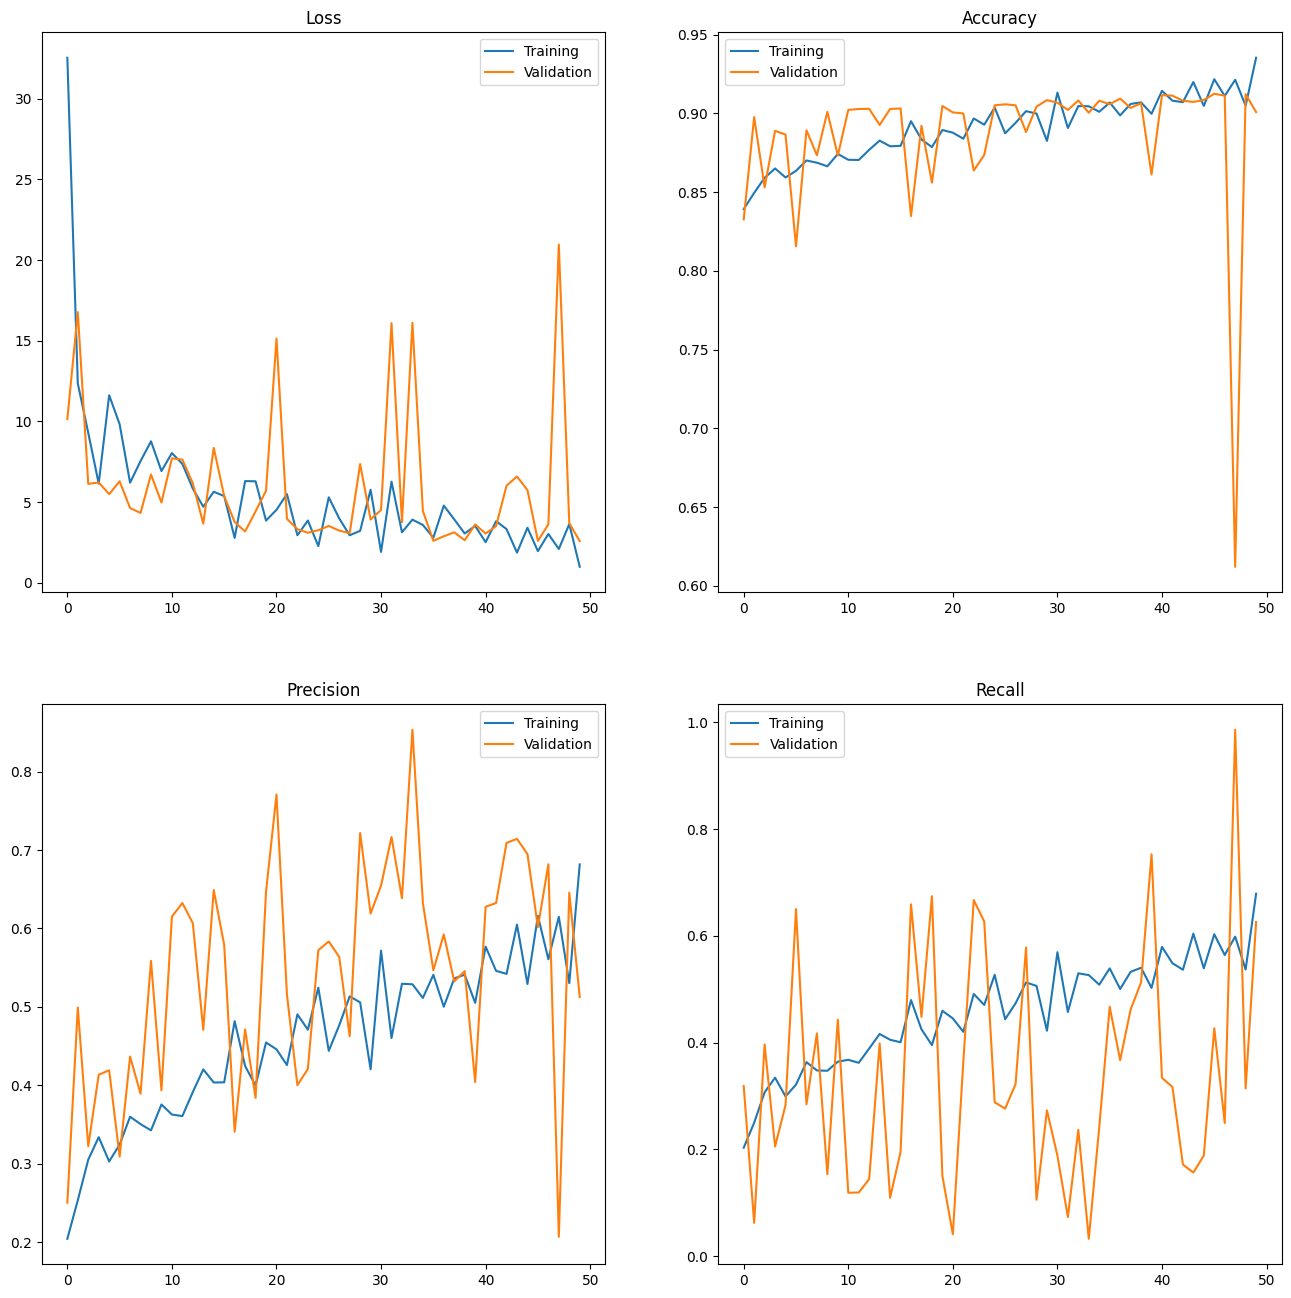

2022-12-27 08:05:43.588599: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_853883"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:10177"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_P

   1/3420 [..............................] - ETA: 58:13

2022-12-27 08:05:44.482619: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(1960335644072036992), session_name()
2022-12-27 08:05:44.625316: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 1960335644072036992 with session name  took 142.62269ms and succeeded
2022-12-27 08:05:44.626984: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(1960335644072036992), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_16404260714724993152", property.function_library_fingerprint = 10206424126895987785, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(propert

3420/3420 [==============================] - 31s 9ms/step


2022-12-27 08:06:14.666138: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(17226231908705052058), session_name()
2022-12-27 08:06:14.804138: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 17226231908705052058 with session name  took 137.920786ms and succeeded
2022-12-27 08:06:14.805465: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(17226231908705052058), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_16404260714724993152", property.function_library_fingerprint = 10206424126895987785, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(pro

Accuracy         0.900292
Precision        0.500892
Recall           0.615912
F1 Score         0.552479
Jaccard Score    0.381673
dtype: float64


,precision,recall,f1-score,support
0,0.956,0.932,0.944,98494.0
1,0.501,0.616,0.552,10935.0
accuracy,0.900,0.900,0.900,0.9
macro avg,0.729,0.774,0.748,109429.0
weighted avg,0.911,0.900,0.905,109429.0


In [21]:
nn5 = neural_network([2048])
nn5, curves_nn5, values_nn5, report_nn5 = train_fit_model(nn5)
nn5.save_weights("nn5.h5")
report_nn5.round(3)

In [22]:
pd.DataFrame({
    "cnn1d-1": values_cnn1d,
    "nn1": values_nn1,
    "nn2": values_nn2,
    "nn3": values_nn3,
    "nn4": values_nn4,
    "nn5": values_nn5
}).T[["Accuracy", "Recall", "Precision", "F1 Score"]]

,Accuracy,Recall,Precision,F1 Score
cnn1d-1,0.908827,0.780338,0.529737,0.631069
nn1,0.900045,0.000091,0.200000,0.000183
nn2,0.903600,0.386740,0.523910,0.444994
nn3,0.841989,0.753361,0.360809,0.487932
nn4,0.899140,0.504710,0.495422,0.500023
nn5,0.900292,0.615912,0.500892,0.552479


In [23]:
X_img = X.reshape(-1, 3, 16, 16).transpose((0, 2, 3, 1))
X_img.shape

(1094288, 16, 16, 3)

In [25]:
minval = X_img.min(axis=(1, 2)).reshape(-1, 1, 1, 3)
minval.shape

(1094288, 1, 1, 3)

In [27]:
maxval = X_img.max(axis=(1, 2)).reshape(-1, 1, 1, 3)
maxval.shape

(1094288, 1, 1, 3)

In [28]:
X_img_norm = (X_img - minval) / (maxval - minval)
X_img_norm.shape

(1094288, 16, 16, 3)

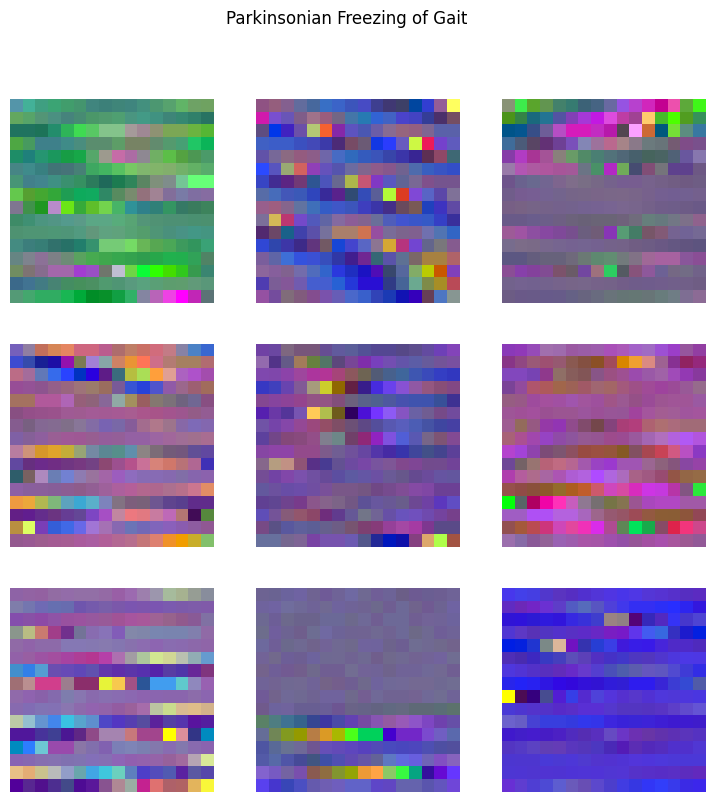

In [67]:
positive_images = X_img_norm[y == 1]
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
plt.suptitle("Parkinsonian Freezing of Gait")
for i, idx in enumerate(np.random.randint(positive_images.shape[0], size=9)):
    axes[i//3, i%3].imshow(positive_images[idx])
    axes[i//3, i%3].axis('off')

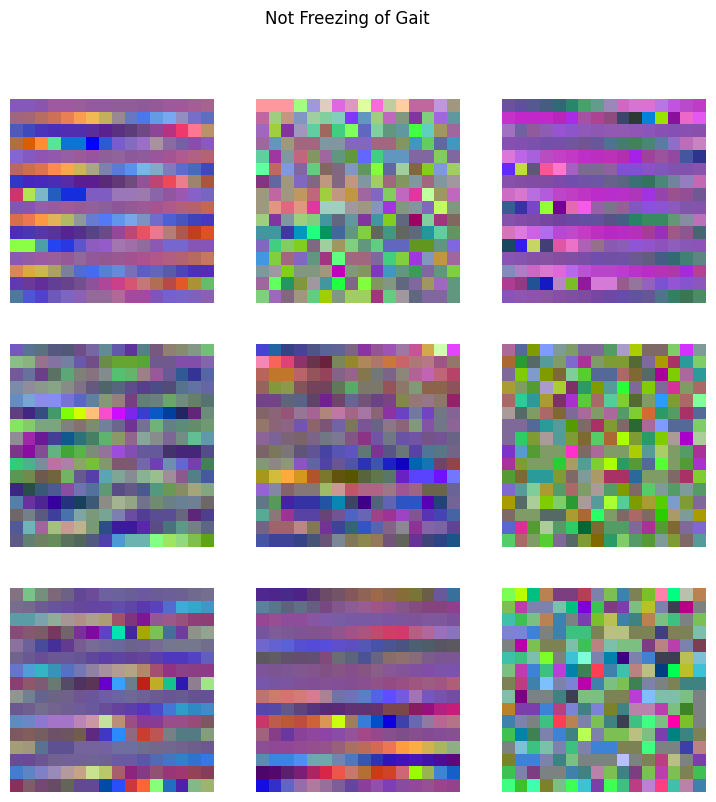

In [68]:
negative_images = X_img_norm[y == 0]
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
plt.suptitle("Not Freezing of Gait")
for i, idx in enumerate(np.random.randint(negative_images.shape[0], size=9)):
    axes[i//3, i%3].imshow(negative_images[idx])
    axes[i//3, i%3].axis('off')

In [47]:
def img_process(X):
    X_img = X.reshape(-1, 3, 16, 16).transpose((0, 2, 3, 1))
    minval = X_img.min(axis=(1, 2)).reshape(-1, 1, 1, 3)
    maxval = X_img.max(axis=(1, 2)).reshape(-1, 1, 1, 3)
    X_img_norm = (X_img - minval) / (maxval - minval)
    return X_img_norm

X_train_img = img_process(X_train)
X_val_img = img_process(X_val)
X_test_img = img_process(X_test)